In [1]:
%config IPCompleter.greedy=True

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from xgboost import XGBRFRegressor, XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error


In [3]:
df = pd.read_json('json_archive/model_5_df.json')
df['Date/Time (PST)'] = pd.to_datetime(df['Date/Time (PST)'])

In [4]:
df.head()

,Date/Time (PST),Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),...,month,max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow
0,2015-12-04 00:00:00,12.76,30.29,0.022,3.943,21.500,259.8,2015-12-04,2.499,25.66,...,12,30.29,20.94,32.02,13.81,21.50,21.50,46.490,46.49,46.49
1,2015-12-04 01:00:00,13.51,29.98,0.000,3.109,10.390,278.7,2015-12-04,2.701,23.25,...,12,30.29,21.20,32.02,15.03,21.50,21.50,46.490,46.49,46.49
10,2015-12-04 10:00:00,12.74,29.41,0.000,2.261,7.299,261.7,2015-12-04,1.083,26.44,...,12,30.29,23.39,30.29,17.25,21.50,21.50,2.701,46.49,46.49
100,2015-12-06 04:00:00,12.81,25.22,1.162,2.183,3.178,94.4,2015-12-06,0.401,35.68,...,12,25.22,23.93,25.22,23.93,7.19,7.19,10.610,10.61,10.61
1000,2016-01-05 16:00:00,12.77,24.26,1.447,2.001,2.740,85.4,2016-01-05,0.664,76.38,...,1,25.84,18.47,25.84,14.10,9.89,10.43,4.284,46.49,46.49


In [5]:
df.head()

,Date/Time (PST),Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),...,month,max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow
0,2015-12-04 00:00:00,12.76,30.29,0.022,3.943,21.500,259.8,2015-12-04,2.499,25.66,...,12,30.29,20.94,32.02,13.81,21.50,21.50,46.490,46.49,46.49
1,2015-12-04 01:00:00,13.51,29.98,0.000,3.109,10.390,278.7,2015-12-04,2.701,23.25,...,12,30.29,21.20,32.02,15.03,21.50,21.50,46.490,46.49,46.49
10,2015-12-04 10:00:00,12.74,29.41,0.000,2.261,7.299,261.7,2015-12-04,1.083,26.44,...,12,30.29,23.39,30.29,17.25,21.50,21.50,2.701,46.49,46.49
100,2015-12-06 04:00:00,12.81,25.22,1.162,2.183,3.178,94.4,2015-12-06,0.401,35.68,...,12,25.22,23.93,25.22,23.93,7.19,7.19,10.610,10.61,10.61
1000,2016-01-05 16:00:00,12.77,24.26,1.447,2.001,2.740,85.4,2016-01-05,0.664,76.38,...,1,25.84,18.47,25.84,14.10,9.89,10.43,4.284,46.49,46.49


In [6]:
df = df.sort_values(by='Date/Time (PST)',ascending=True)

In [7]:
df.head()

,Date/Time (PST),Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),...,month,max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow
0,2015-12-04 00:00:00,12.76,30.29,0.022,3.943,21.50,259.8,2015-12-04,2.499,25.66,...,12,30.29,20.94,32.02,13.81,21.5,21.5,46.49,46.49,46.49
1,2015-12-04 01:00:00,13.51,29.98,0.000,3.109,10.39,278.7,2015-12-04,2.701,23.25,...,12,30.29,21.20,32.02,15.03,21.5,21.5,46.49,46.49,46.49
2,2015-12-04 02:00:00,12.81,29.98,0.000,2.432,8.70,266.3,2015-12-04,2.295,23.77,...,12,30.29,21.33,32.02,16.86,21.5,21.5,46.49,46.49,46.49
3,2015-12-04 03:00:00,12.79,30.01,0.000,3.243,14.31,279.1,2015-12-04,2.566,25.66,...,12,30.29,21.33,32.02,17.25,21.5,21.5,46.49,46.49,46.49
4,2015-12-04 04:00:00,12.78,29.08,0.000,6.408,19.64,285.1,2015-12-04,1.756,25.71,...,12,30.29,21.54,32.02,17.25,21.5,21.5,46.43,46.49,46.49


In [8]:
ddf = df.copy()
ddf['id'] = ddf.index
ddf['Date'] = ddf['Date/Time (PST)']
ddf.index = ddf['Date/Time (PST)']
ddf = ddf.drop('Date/Time (PST)', axis=1)

In [9]:
ddf.loc[ddf["Date"] == '2015-12-04 01:00:00',"Date"]

Date/Time (PST)
2015-12-04 01:00:00   2015-12-04 01:00:00
Name: Date, dtype: datetime64[ns]

In [10]:
df.loc[df["Date/Time (PST)"] == '2015-12-04 01:00:00','Date/Time (PST)']

1   2015-12-04 01:00:00
Name: Date/Time (PST), dtype: datetime64[ns]

In [11]:
ddf.head()

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),area,...,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,id,Date
Date/Time (PST),,,,,,,,,,,,,,,,,,,,,
2015-12-04 00:00:00,12.76,30.29,0.022,3.943,21.50,259.8,2015-12-04,2.499,25.66,Stevens Pass,...,20.94,32.02,13.81,21.5,21.5,46.49,46.49,46.49,0,2015-12-04 00:00:00
2015-12-04 01:00:00,13.51,29.98,0.000,3.109,10.39,278.7,2015-12-04,2.701,23.25,Stevens Pass,...,21.20,32.02,15.03,21.5,21.5,46.49,46.49,46.49,1,2015-12-04 01:00:00
2015-12-04 02:00:00,12.81,29.98,0.000,2.432,8.70,266.3,2015-12-04,2.295,23.77,Stevens Pass,...,21.33,32.02,16.86,21.5,21.5,46.49,46.49,46.49,2,2015-12-04 02:00:00
2015-12-04 03:00:00,12.79,30.01,0.000,3.243,14.31,279.1,2015-12-04,2.566,25.66,Stevens Pass,...,21.33,32.02,17.25,21.5,21.5,46.49,46.49,46.49,3,2015-12-04 03:00:00
2015-12-04 04:00:00,12.78,29.08,0.000,6.408,19.64,285.1,2015-12-04,1.756,25.71,Stevens Pass,...,21.54,32.02,17.25,21.5,21.5,46.43,46.49,46.49,4,2015-12-04 04:00:00


In [12]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15723 entries, 2015-12-04 00:00:00 to 2019-04-13 23:00:00
Data columns (total 26 columns):
Battery Voltage (v)         15723 non-null float64
Temperature (deg F)         15723 non-null float64
Wind Speed Minimum (mph)    15723 non-null float64
Wind Speed Average (mph)    15723 non-null float64
Wind Speed Maximum (mph)    15723 non-null float64
Wind Direction (deg.)       15723 non-null float64
date                        15723 non-null datetime64[ns]
24 Hour Snow (in)           15723 non-null float64
Total Snow Depth (in)       15723 non-null float64
area                        15723 non-null object
danger_above_treeline       15723 non-null int64
danger_below_treeline       15723 non-null int64
danger_near_treeline        15723 non-null int64
date_tomorrow               15723 non-null object
month                       15723 non-null int64
max_1_day_temp              15723 non-null float64
min_1_day_temp              15723 non-null 

In [13]:
# def get_previous_day_snow_kv(df, dt):
#     target_hour = dt - pd.Timedelta('1 day')
#     if target_hour in df.Date:
#         return df.loc[target_hour,'24 Hour Snow (in)']
#     else:
#         return None

In [14]:
# get_previous_day_snow_kv(ddf,'2015-12-04 01:00:00')

In [15]:
def get_previous_day_snow(df, dt):
    target_hour = dt - pd.Timedelta('1 day')
    if target_hour in df.index:
        return df.loc[target_hour, '24 Hour Snow (in)']
    else:
        return np.nan

In [16]:
ddf['Prev Day 24 Hour Snow (in)'] = [get_previous_day_snow(ddf, dt) for dt in ddf.index]

In [17]:
ddf.shape , df.shape

((15723, 27), (15723, 25))

In [18]:
# weather.Temp.convert_objects(convert_numeric=True)

In [20]:
ddf['Prev Day 24 Hour Snow (in)'].astype(float,errors='ignore')

Date/Time (PST)
2015-12-04 00:00:00                                                  NaN
2015-12-04 01:00:00                                                  NaN
2015-12-04 02:00:00                                                  NaN
2015-12-04 03:00:00                                                  NaN
2015-12-04 04:00:00                                                  NaN
2015-12-04 05:00:00                                                  NaN
2015-12-04 06:00:00                                                  NaN
2015-12-04 07:00:00                                                  NaN
2015-12-04 08:00:00                                                  NaN
2015-12-04 09:00:00                                                  NaN
2015-12-04 10:00:00                                                  NaN
2015-12-04 11:00:00                                                  NaN
2015-12-04 12:00:00                                                  NaN
2015-12-04 13:00:00                

In [25]:
#from pandas.api.types import is_numeric_dtype

In [26]:
#ddf.loc[ddf['Prev Day 24 Hour Snow (in)'].apply(lambda x: x.is_numeric_dtype)]

In [27]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15723 entries, 2015-12-04 00:00:00 to 2019-04-13 23:00:00
Data columns (total 27 columns):
Battery Voltage (v)           15723 non-null float64
Temperature (deg F)           15723 non-null float64
Wind Speed Minimum (mph)      15723 non-null float64
Wind Speed Average (mph)      15723 non-null float64
Wind Speed Maximum (mph)      15723 non-null float64
Wind Direction (deg.)         15723 non-null float64
date                          15723 non-null datetime64[ns]
24 Hour Snow (in)             15723 non-null float64
Total Snow Depth (in)         15723 non-null float64
area                          15723 non-null object
danger_above_treeline         15723 non-null int64
danger_below_treeline         15723 non-null int64
danger_near_treeline          15723 non-null int64
date_tomorrow                 15723 non-null object
month                         15723 non-null int64
max_1_day_temp                15723 non-null float64
min_1_day_t

In [28]:
ddf_clean = ddf.dropna()

In [29]:
ddf_clean.isna().sum()

Battery Voltage (v)           0
Temperature (deg F)           0
Wind Speed Minimum (mph)      0
Wind Speed Average (mph)      0
Wind Speed Maximum (mph)      0
Wind Direction (deg.)         0
date                          0
24 Hour Snow (in)             0
Total Snow Depth (in)         0
area                          0
danger_above_treeline         0
danger_below_treeline         0
danger_near_treeline          0
date_tomorrow                 0
month                         0
max_1_day_temp                0
min_1_day_temp                0
max_2_day_temp                0
min_2_day_temp                0
max_1_day_wind                0
max_2_day_wind                0
max_1_day_snow                0
max_2_day_snow                0
max_3_day_snow                0
id                            0
Date                          0
Prev Day 24 Hour Snow (in)    0
dtype: int64

In [30]:
ddf_clean[['Prev Day 24 Hour Snow (in)']]

,Prev Day 24 Hour Snow (in)
Date/Time (PST),
2015-12-05 00:00:00,2.499
2015-12-05 00:00:00,2.499
2015-12-05 00:00:00,2.499
2015-12-05 01:00:00,2.701
2015-12-05 01:00:00,2.701
2015-12-05 01:00:00,2.701
2015-12-05 02:00:00,2.295
2015-12-05 02:00:00,2.295
2015-12-05 02:00:00,2.295


In [31]:
ddf = ddf[:15698]

In [32]:
ddf.shape[0]-25

15673

The function created is not outputting numbers, rather objects

In [33]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15698 entries, 2015-12-04 00:00:00 to 2019-04-12 23:00:00
Data columns (total 27 columns):
Battery Voltage (v)           15698 non-null float64
Temperature (deg F)           15698 non-null float64
Wind Speed Minimum (mph)      15698 non-null float64
Wind Speed Average (mph)      15698 non-null float64
Wind Speed Maximum (mph)      15698 non-null float64
Wind Direction (deg.)         15698 non-null float64
date                          15698 non-null datetime64[ns]
24 Hour Snow (in)             15698 non-null float64
Total Snow Depth (in)         15698 non-null float64
area                          15698 non-null object
danger_above_treeline         15698 non-null int64
danger_below_treeline         15698 non-null int64
danger_near_treeline          15698 non-null int64
date_tomorrow                 15698 non-null object
month                         15698 non-null int64
max_1_day_temp                15698 non-null float64
min_1_day_t

In [34]:
ddf_clean.describe()

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),24 Hour Snow (in),Total Snow Depth (in),danger_above_treeline,danger_below_treeline,...,max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,id
count,15209.000000,15209.000000,15209.000000,15209.000000,15209.000000,15209.000000,15209.000000,15209.000000,15209.000000,15209.000000,...,15209.000000,15209.000000,15209.000000,15209.000000,15209.000000,15209.000000,15209.000000,15209.000000,15209.000000,15209.000000
mean,12.711188,25.525136,1.554919,5.866815,12.183691,179.461191,3.493889,92.285889,2.563219,2.066342,...,30.140378,21.994387,32.276292,20.480700,21.397124,25.806316,12.824797,18.196964,22.208526,7927.159248
std,0.222982,8.021825,2.498873,4.921001,8.651622,97.956147,10.203386,28.089099,0.772244,0.773631,...,8.542779,7.350915,8.499448,7.238008,11.481203,12.207243,18.610324,20.558248,21.151144,4548.580111
min,12.430000,-2.007000,0.000000,0.000000,0.000000,0.000000,-12.000000,0.000000,1.000000,1.000000,...,1.173000,-2.007000,6.934000,-2.007000,0.000000,0.000000,-2.916000,-1.043000,0.386000,24.000000
25%,12.600000,20.960000,0.000000,2.902000,6.971000,86.500000,0.291000,73.900000,2.000000,2.000000,...,24.660000,17.980000,26.630000,16.510000,12.800000,16.160000,0.624000,1.231000,2.821000,4051.000000
50%,12.660000,25.650000,0.110000,4.409000,9.890000,233.200000,0.512000,91.900000,3.000000,2.000000,...,29.940000,22.820000,31.890000,21.370000,18.020000,23.740000,2.863000,5.388000,9.610000,8022.000000
75%,12.730000,30.420000,2.302000,7.283000,14.550000,270.400000,2.402000,114.100000,3.000000,3.000000,...,34.560000,26.860000,37.180000,25.170000,28.010000,33.250000,12.750000,46.490000,46.490000,11848.000000
max,14.670000,67.010000,21.240000,35.030000,71.790000,359.200000,75.000000,220.500000,4.000000,4.000000,...,67.010000,46.530000,67.880000,44.570000,71.790000,71.790000,75.000000,75.000000,75.000000,15722.000000


In [35]:
X = ddf_clean[['Battery Voltage (v)', 'Temperature (deg F)',
            'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
            'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
            '24 Hour Snow (in)', 'Total Snow Depth (in)','max_1_day_temp',
            'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
            'max_1_day_snow',
       ]]

y = ddf_clean['danger_near_treeline']

X_train, X_test, y_train, y_test = X[:12578], X[12578:], y[:12578], y[12578:]

In [36]:
ss = StandardScaler()

lr = LinearRegression()
rfr = RandomForestRegressor(n_estimators=100)
gbr = GradientBoostingRegressor(n_estimators=100)
knnr = KNeighborsRegressor()
regressors = [lr, rfr, gbr, knnr ]

reg_names = ['LinearRegression',
             'RandomForestRegressor',
             'GradientBoostingRegressor',
             'KNeighborsRegressor',
            ]

In [37]:
mapper = DataFrameMapper([
    ([   'Battery Voltage (v)', 'Temperature (deg F)',
            'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
            'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
            '24 Hour Snow (in)', 'Total Snow Depth (in)','max_1_day_temp',
            'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
            'max_1_day_snow',], ss)
    ])

In [38]:
baseline_pred = np.mean(y_train)
residuals = (y_test - baseline_pred)
median_absolute_error = np.median(np.abs(residuals))
rmse=np.sqrt(np.mean(residuals**2))

print(median_absolute_error,rmse)

print(f'The MAE of just predicting the mean'
          f' is: {median_absolute_error}\n'
          f'The RMSE just predicting the mean'
          f' is: {rmse}\n'
      '==================================================================\n'
          '========================\n')

for regressor,name in zip(regressors,reg_names): #zip returns a tuple for each pair it is given
    pipe = Pipeline(steps=[
        #('scaler',mapper),
        ('regressor', regressor)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(f'The MAE of the {name}'
          f' is: {mean_absolute_error((y_test),preds)}\n'
          f'The RMSE of the {name}'
          f' is: {mean_squared_error((y_test),preds)}\n'
          '==================================================================\n'
          '========================\n'
         )
    

0.5536651295913502 0.9174265991796509
The MAE of just predicting the mean is: 0.5536651295913502
The RMSE just predicting the mean is: 0.9174265991796509

The MAE of the LinearRegression is: 0.7339066318362456
The RMSE of the LinearRegression is: 0.7281861048285986

The MAE of the RandomForestRegressor is: 0.7460030753591187
The RMSE of the RandomForestRegressor is: 0.7932273356313416

The MAE of the GradientBoostingRegressor is: 0.6811701289141523
The RMSE of the GradientBoostingRegressor is: 0.6566580350663463

The MAE of the KNeighborsRegressor is: 0.7820600532117066
The RMSE of the KNeighborsRegressor is: 0.9210186240973013



In [39]:
precip_df= pd.read_csv('csv_files/stevens_pass_precipitation_2014_now.csv')


precip_df.columns 

Index(['Date/Time (PST)', '" - 2700' - Berne',
       '" - 3950' - Stevens Pass - Schmidt Haus',
       '" - 4800' - Stevens Pass - Brooks Precipitation'],
      dtype='object')

In [40]:
precip_df.columns = ['Date/Time (PST)', '2700ft_berne',
       '3950ft_schmidt_haus',
       '4800_brooks']

In [41]:
precip_df.describe()

,2700ft_berne,3950ft_schmidt_haus,4800_brooks
count,40954.000000,41685.000000,31005.000000
mean,0.006208,0.009511,0.008432
std,0.021681,0.030280,0.122046
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,0.450000,1.900000,21.090000


In [42]:
precip_df['Date/Time (PST)'] = pd.to_datetime(precip_df['Date/Time (PST)'])

In [43]:
precip_ddf = precip_df.copy()
precip_ddf['id'] = precip_ddf.index
precip_ddf.index = precip_ddf['Date/Time (PST)']
precip_ddf = precip_ddf.drop('Date/Time (PST)', axis=1)

In [44]:
df_merge = pd.merge(ddf,precip_df,how='left',on="Date/Time (PST)")

In [45]:
df_merge.describe()

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),24 Hour Snow (in),Total Snow Depth (in),danger_above_treeline,danger_below_treeline,...,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,id,2700ft_berne,3950ft_schmidt_haus,4800_brooks
count,15698.000000,15698.000000,15698.000000,15698.000000,15698.000000,15698.000000,15698.000000,15698.000000,15698.000000,15698.000000,...,15698.000000,15698.000000,15698.000000,15698.000000,15698.000000,15698.000000,15698.000000,15694.000000,15692.000000,15694.000000
mean,12.712141,25.680427,1.551580,5.855301,12.157988,180.076752,3.623809,91.809278,2.559371,2.059817,...,20.581941,21.304314,25.694263,12.949529,18.362162,22.390681,7848.500127,0.010519,0.015007,0.013448
std,0.222969,8.176341,2.495386,4.905229,8.597350,97.754072,10.688088,28.589787,0.765453,0.768927,...,7.374213,11.463332,12.218025,18.991450,20.990676,21.603821,4531.766819,0.026664,0.033492,0.170316
min,12.430000,-2.007000,0.000000,0.000000,0.000000,0.000000,-12.000000,0.000000,1.000000,1.000000,...,-2.007000,0.000000,0.000000,-2.916000,-1.043000,0.386000,0.000000,0.000000,0.000000,0.000000
25%,12.600000,21.072500,0.000000,2.884500,6.992000,86.700000,0.292000,73.430000,2.000000,2.000000,...,16.590000,12.635000,15.850000,0.624000,1.217000,2.821000,3924.250000,0.000000,0.000000,0.000000
50%,12.660000,25.775000,0.088000,4.398000,9.860000,236.600000,0.512000,91.800000,3.000000,2.000000,...,21.430000,17.930000,23.610000,2.828000,5.380000,9.610000,7848.500000,0.000000,0.000000,0.000000
75%,12.730000,30.490000,2.324000,7.283750,14.530000,270.400000,2.408000,114.100000,3.000000,3.000000,...,25.240000,27.750000,32.970000,12.560000,46.490000,46.490000,11772.750000,0.010000,0.010000,0.010000
max,14.670000,67.010000,21.240000,35.030000,71.790000,359.200000,75.000000,220.500000,4.000000,4.000000,...,48.340000,71.790000,71.790000,75.000000,75.000000,75.000000,15698.000000,0.360000,0.370000,21.090000


In [46]:
df_merge.columns

Index(['Date/Time (PST)', 'Battery Voltage (v)', 'Temperature (deg F)',
       'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
       'Wind Speed Maximum (mph)', 'Wind Direction (deg.)', 'date',
       '24 Hour Snow (in)', 'Total Snow Depth (in)', 'area',
       'danger_above_treeline', 'danger_below_treeline',
       'danger_near_treeline', 'date_tomorrow', 'month', 'max_1_day_temp',
       'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp', 'max_1_day_wind',
       'max_2_day_wind', 'max_1_day_snow', 'max_2_day_snow', 'max_3_day_snow',
       'id', 'Date', 'Prev Day 24 Hour Snow (in)', '2700ft_berne',
       '3950ft_schmidt_haus', '4800_brooks'],
      dtype='object')

In [97]:
df_cleaned = df_merge.dropna()

In [116]:
df_cleaned.shape[0]*.80

12142.400000000001

In [117]:
mapper = DataFrameMapper([
    ([   'Battery Voltage (v)','Temperature (deg F)',
            'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
            'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
            '24 Hour Snow (in)', 'Total Snow Depth (in)','max_1_day_temp',
            'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
            'max_1_day_snow','max_2_day_snow','max_3_day_snow','4800_brooks'], ss)
    ])

X = df_cleaned[['Battery Voltage (v)','Temperature (deg F)',
            'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
            'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
            '24 Hour Snow (in)', 'Total Snow Depth (in)','max_1_day_temp',
            'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
            'max_1_day_snow','max_2_day_snow','max_3_day_snow','4800_brooks']]

y = df_cleaned['danger_near_treeline']

X_train, X_test, y_train, y_test = X[:12142], X[12142:], y[:12142], y[12142:]

In [118]:
baseline_pred = np.mean(y_train)
residuals = (y_test - baseline_pred)
median_absolute_error = np.median(np.abs(residuals))
rmse=np.sqrt(np.mean(residuals**2))

print(median_absolute_error,rmse)

print(f'The MAE of just predicting the mean'
          f' is: {median_absolute_error}\n'
          f'The RMSE just predicting the mean'
          f' is: {rmse}\n'
      '==================================================================\n'
          '========================\n')

for regressor,name in zip(regressors,reg_names): #zip returns a tuple for each pair it is given
    pipe = Pipeline(steps=[
        ('scaler',mapper),
        ('regressor', regressor)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(f'The MAE of the {name}'
          f' is: {mean_absolute_error((y_test),preds)}\n'
          f'The RMSE of the {name}'
          f' is: {mean_squared_error((y_test),preds)}\n'
          '==================================================================\n'
          '========================\n'
         )
    

0.5470268489540437 0.8828165829611628
The MAE of just predicting the mean is: 0.5470268489540437
The RMSE just predicting the mean is: 0.8828165829611628

The MAE of the LinearRegression is: 0.7057367569191303
The RMSE of the LinearRegression is: 0.6728951547801117

The MAE of the RandomForestRegressor is: 0.6692807212915909
The RMSE of the RandomForestRegressor is: 0.6645319320089615

The MAE of the GradientBoostingRegressor is: 0.6627965414789484
The RMSE of the GradientBoostingRegressor is: 0.629430917280333

The MAE of the KNeighborsRegressor is: 0.7729907773386034
The RMSE of the KNeighborsRegressor is: 0.8958893280632412



In [119]:
pipe2 = Pipeline(steps=[
('scaler',mapper),
('regressor', gbr)
])
pipe2.fit(X_train, y_train)
preds = pipe2.predict(X_test)
print(f'The MAE of the {name}'
f' is: {mean_absolute_error((y_test),preds)}\n'
f'The RMSE of the regressor is:'
f' is: {mean_squared_error((y_test),preds)}\n'
'==================================================================\n'
'========================\n'
)

The MAE of the KNeighborsRegressor is: 0.6644106019745536
The RMSE of the regressor is: is: 0.6343887788297886



In [120]:
y_predict = list(pipe2.predict(X_test))

In [121]:
len(y_test),len(y_predict)

(3036, 3036)

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline  

In [123]:
X_test.head()

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),24 Hour Snow (in),Total Snow Depth (in),max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_snow,max_2_day_snow,max_3_day_snow,4800_brooks
12661,12.59,18.66,3.836,6.568,9.82,93.7,0.325,68.59,21.43,17.77,32.40,17.77,0.459,3.966,3.966,0.0
12662,12.58,20.67,3.135,6.068,8.64,96.6,0.329,68.47,21.43,17.77,32.40,17.77,0.459,3.966,3.966,0.0
12663,12.57,21.32,4.274,6.268,9.18,100.2,0.340,68.50,21.43,17.77,32.26,17.77,0.459,3.966,3.966,0.0
12664,12.57,20.49,0.066,5.838,9.80,93.6,0.341,68.57,21.43,17.77,31.31,17.77,0.459,3.966,3.966,0.0
12665,12.56,20.49,1.249,5.496,10.46,92.4,0.206,68.77,21.43,17.77,29.51,17.77,0.459,3.966,3.966,0.0


In [124]:
len(y_predict)

3036

In [125]:
y_predict = np.array(y_predict)

In [126]:
type(y_test),len(y_test)

(pandas.core.series.Series, 3036)

In [127]:
df_y = (pd.DataFrame({'y_true':y_test,'y_predict':y_predict}))

In [128]:
import seaborn as sns
sns.set(style="whitegrid")


def violin_plot_error(model, X, y_true, rescale=False):
    y_pred = model.predict(X)
    if rescale:
        y_pred_95 = np.percentile(y_pred, 95)
        y_pred_5 = np.percentile(y_pred, 5)
        scaling_factor = 3 / (y_pred_95 - y_pred_5)
        y_pred -= y_pred_5
        y_pred *= scaling_factor
        y_pred += 1
    df_y = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    fig, axes = plt.subplots()
    #sns.violinplot(x='groups',y='danger level', data=df_violin, ax = axes)
    sns.violinplot(x='y_true',y='y_pred', data=df_y, ax=axes)# df_y['y_predict_round'] = np.round(df_y['y_predict'])

In [129]:
y_preds = pipe.predict(X_test)

In [130]:
y_pred_95 = np.percentile(y_preds, 95)
y_pred_5 = np.percentile(y_preds, 5)

In [131]:
scaling_factor = 3 / (y_pred_95 - y_pred_5)

In [132]:
y_preds -= y_pred_5

In [133]:
y_preds *= scaling_factor

In [134]:
y_preds += 1

In [135]:
y_preds[200]

2.6666666666666665

In [136]:
# df_violin = pd.melt(df_y,var_name='groups',value_name='danger level')

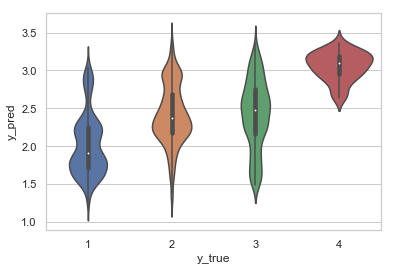

In [137]:
violin_plot_error(pipe2, X_test, y_test)

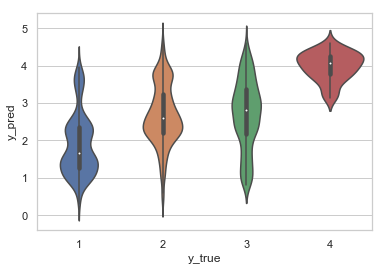

In [138]:
violin_plot_error(pipe2, X_test, y_test, rescale=True)


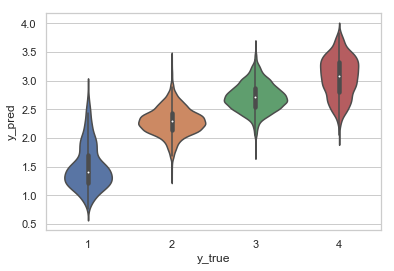

In [139]:
violin_plot_error(pipe2, X_train, y_train)

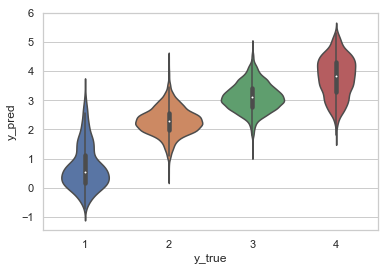

In [140]:
violin_plot_error(pipe2, X_train, y_train,rescale=True)

In [141]:
pipe2.steps

[('scaler', DataFrameMapper(default=False, df_out=False,
                  features=[(['Battery Voltage (v)', 'Temperature (deg F)',
                              'Wind Speed Minimum (mph)',
                              'Wind Speed Average (mph)',
                              'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
                              '24 Hour Snow (in)', 'Total Snow Depth (in)',
                              'max_1_day_temp', 'min_1_day_temp',
                              'max_2_day_temp', 'min_2_day_temp',
                              'max_1_day_snow', 'max_2_day_snow',
                              'max_3_day_snow', '4800_brooks'],
                             StandardScaler(copy=True, with_mean=True,
                                            with_std=True))],
                  input_df=False, sparse=False)),
 ('regressor',
  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='ls'

In [87]:
import pickle

In [142]:
# save the model to disk
filename = 'avy_danger_prediction.pkl'
pickle.dump(pipe2, open(filename, 'wb'))
 

In [143]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [144]:
X_test[1:2]

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),24 Hour Snow (in),Total Snow Depth (in),max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_snow,max_2_day_snow,max_3_day_snow,4800_brooks
12662,12.58,20.67,3.135,6.068,8.64,96.6,0.329,68.47,21.43,17.77,32.4,17.77,0.459,3.966,3.966,0.0


In [145]:
X_test.columns

Index(['Battery Voltage (v)', 'Temperature (deg F)',
       'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
       'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
       '24 Hour Snow (in)', 'Total Snow Depth (in)', 'max_1_day_temp',
       'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp', 'max_1_day_snow',
       'max_2_day_snow', 'max_3_day_snow', '4800_brooks'],
      dtype='object')

In [146]:
result = loaded_model.predict(X_test[1:2])
print(result)

[2.13637788]


In [147]:
X_test.head()

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),24 Hour Snow (in),Total Snow Depth (in),max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_snow,max_2_day_snow,max_3_day_snow,4800_brooks
12661,12.59,18.66,3.836,6.568,9.82,93.7,0.325,68.59,21.43,17.77,32.40,17.77,0.459,3.966,3.966,0.0
12662,12.58,20.67,3.135,6.068,8.64,96.6,0.329,68.47,21.43,17.77,32.40,17.77,0.459,3.966,3.966,0.0
12663,12.57,21.32,4.274,6.268,9.18,100.2,0.340,68.50,21.43,17.77,32.26,17.77,0.459,3.966,3.966,0.0
12664,12.57,20.49,0.066,5.838,9.80,93.6,0.341,68.57,21.43,17.77,31.31,17.77,0.459,3.966,3.966,0.0
12665,12.56,20.49,1.249,5.496,10.46,92.4,0.206,68.77,21.43,17.77,29.51,17.77,0.459,3.966,3.966,0.0
